In [235]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))
df_raw['churn_concern'] = df_raw['churn_concern'].fillna(0).astype(int)

In [237]:
df_raw.account_status

0          NaN
1       Active
2       Active
3       Active
4       Active
         ...  
5884    Active
5885    Active
5886    Active
5887    Active
5888    Active
Name: account_status, Length: 5889, dtype: object

In [238]:
# Converted all cases fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours']

for case_type in case_types:
    df_raw[case_type] = df_raw[case_type].fillna(df_raw[case_type].mean()).astype(int)

In [239]:
#df_raw.loc[df_raw.plan=='PLAN-S-19Q1', 'annual_revenue'].fillna(round(df_raw.annual_revenue[df_raw.plan == 'PLAN-S-19Q1'].mean(), 2))

In [240]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    plan_revenue_mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    
    if pd.isnull(plan_revenue_mean):
        revenue = 0
    else:
        revenue = plan_revenue_mean
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'] = df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

In [241]:
import pandas as pd

def quick_analysis(df):
 print("Data Types:")
 print(df.dtypes)
 print("Rows and Columns:")
 print(df.shape)
 print("Column Names:")
 print(df.columns)
 print("Null Values:")
 print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    
quick_analysis(df_raw)

Data Types:
username                                   object
merchant                                   object
canceldate                         datetime64[ns]
licence_registration_date          datetime64[ns]
days_active                                 int64
account_status                             object
customer_account_status                    object
nps                                       float64
licence_status                             object
cancel_reason                              object
cancel_details                             object
team                                       object
vertical                                   object
plans                                      object
plan                                       object
last_login_days                           float64
last_login_concern                        float64
changing_platform                          object
new_platform                               object
salesperson                           

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3e466150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c3c96c8d0>]], dtype=object)

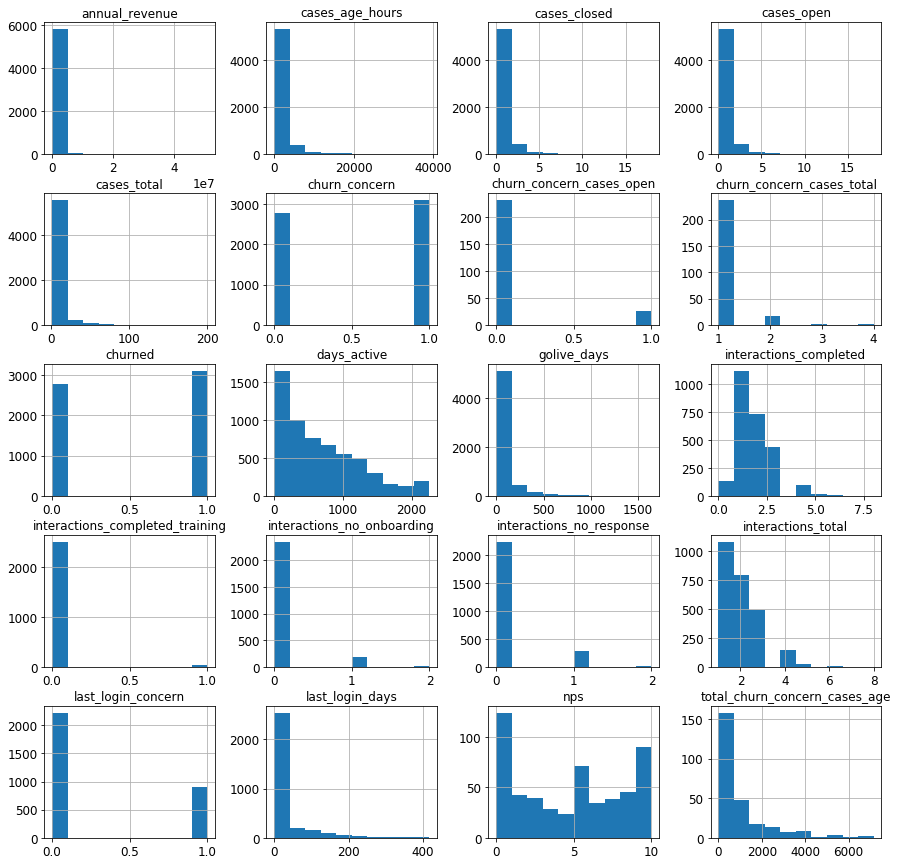

In [242]:
import matplotlib.pyplot as plt
df_raw[df_raw.dtypes[(df_raw.dtypes=="float64")|(df_raw.dtypes=="int64")]
                        .index.values].hist(figsize=[15,15])

In [243]:
#print (df_raw.columns.tolist())
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'account_status', 'customer_account_status', 'nps',
       'licence_status', 'cancel_reason', 'cancel_details', 'team', 'vertical',
       'plans', 'plan', 'last_login_days', 'last_login_concern',
       'changing_platform', 'new_platform', 'salesperson', 'golive_date',
       'golive_days', 'url', 'cases_total', 'cases_open', 'cases_closed',
       'cases_age_hours', 'annual_revenue', 'interactions_total',
       'interactions_completed', 'interactions_no_response',
       'interactions_no_onboarding', 'interactions_completed_training',
       'churn_concern_cases_total', 'churn_concern_cases_open',
       'total_churn_concern_cases_age', 'churned', 'churn_concern'],
      dtype='object')

In [244]:
# A more standard way to one-hot encoding

dummy_columns = ['account_status', 'customer_account_status']

for dummy_column in dummy_columns:
    print(dummy_column)
    dummy = pd.get_dummies(df_raw[dummy_column], prefix=dummy_column)
    df_raw = pd.concat([df_raw,dummy], axis=1)
    df_raw = df_raw.drop(columns=dummy_column)

account_status
customer_account_status


In [245]:
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'nps', 'licence_status', 'cancel_reason',
       'cancel_details', 'team', 'vertical', 'plans', 'plan',
       'last_login_days', 'last_login_concern', 'changing_platform',
       'new_platform', 'salesperson', 'golive_date', 'golive_days', 'url',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours',
       'annual_revenue', 'interactions_total', 'interactions_completed',
       'interactions_no_response', 'interactions_no_onboarding',
       'interactions_completed_training', 'churn_concern_cases_total',
       'churn_concern_cases_open', 'total_churn_concern_cases_age', 'churned',
       'churn_concern', 'account_status_Active', 'account_status_Cancelled',
       'account_status_Draft', 'account_status_Hold',
       'account_status_Suspended', 'customer_account_status_Good',
       'customer_account_status_PoorStanding'],
      dtype='object')

In [246]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
last_login_categories
pd.value_counts(df_raw['last_login_categories'])

few_days     174
month        143
week         125
fortnight    114
day           80
Name: last_login_categories, dtype: int64

In [247]:
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'nps', 'licence_status', 'cancel_reason',
       'cancel_details', 'team', 'vertical', 'plans', 'plan',
       'last_login_days', 'last_login_concern', 'changing_platform',
       'new_platform', 'salesperson', 'golive_date', 'golive_days', 'url',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours',
       'annual_revenue', 'interactions_total', 'interactions_completed',
       'interactions_no_response', 'interactions_no_onboarding',
       'interactions_completed_training', 'churn_concern_cases_total',
       'churn_concern_cases_open', 'total_churn_concern_cases_age', 'churned',
       'churn_concern', 'account_status_Active', 'account_status_Cancelled',
       'account_status_Draft', 'account_status_Hold',
       'account_status_Suspended', 'customer_account_status_Good',
       'customer_account_status_PoorStanding', 'last_login_categories'],
      dtype='object')

In [248]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [249]:
# Drop columns

df_raw = df_raw.drop(columns=['account_status_Draft', 'account_status_Active', 'account_status_Cancelled', 'changing_platform', 'new_platform', 'licence_status', 'canceldate', 'cancel_details', 'cancel_reason', 'churned'])

In [250]:
len(df_raw[df_raw.churn_concern==1]), len(df_raw[df_raw.churn_concern==0]), len(df_raw)

(3109, 2780, 5889)

In [251]:
# this code was an attempt to do over sampling

#df_copy = df_raw.copy()
#df_copy.append([df_raw[df_raw.churn_concern==1]]*100,ignore_index=True)
#df_copy.append([df_raw[df_raw.churn_concern==0]]*100,ignore_index=True)
#len(df_copy[df_copy.churn_concern==1]), len(df_copy[df_copy.churn_concern==0]), len(df_copy)

In [252]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))
df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))
df_raw.churn_concern = df_raw.churn_concern.fillna(0)

In [253]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)

In [254]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)

In [256]:
len(X_valid), len(X_valid.columns), len(X_train), len(X_train.columns)

(500, 72, 5389, 72)

In [257]:
y_train, y_valid = split_vals(y_trn, n_trn)
#raw_train, raw_valid = split_vals(df_raw, n_trn)
len(y_valid), len(y_train)

(500, 5389)

In [258]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [259]:
validate_predictions = m.predict(X_valid)

In [260]:
validate_predictions

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 

In [261]:
from sklearn.metrics import f1_score, accuracy_score

In [262]:
accuracy_score(y_valid, validate_predictions)

0.924

In [263]:
f1_score(y_valid, validate_predictions)

0.7790697674418605

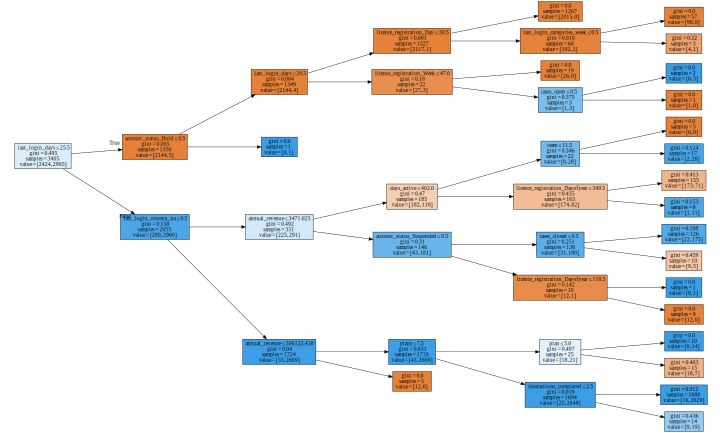

In [264]:
draw_tree(m.estimators_[10], df_trn, precision=3)

In [265]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
8,last_login_days,0.506306
56,last_login_concern_na,0.231242
28,customer_account_status_Good,0.119200
9,last_login_concern,0.020844
17,annual_revenue,0.018123
61,interactions_no_onboarding_na,0.014658
58,interactions_total_na,0.011732
27,account_status_Suspended,0.010867
59,interactions_completed_na,0.009663
16,cases_age_hours,0.007614


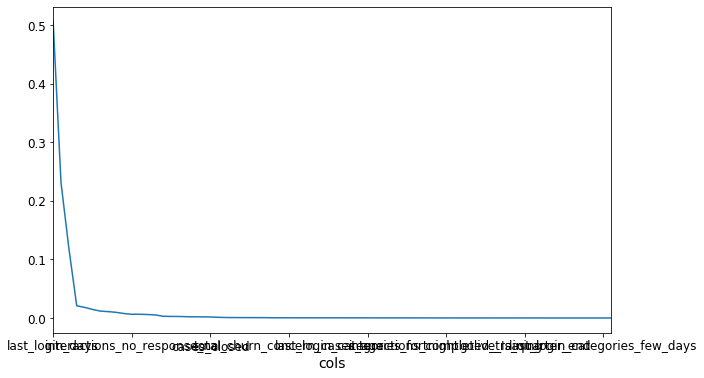

In [266]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [267]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

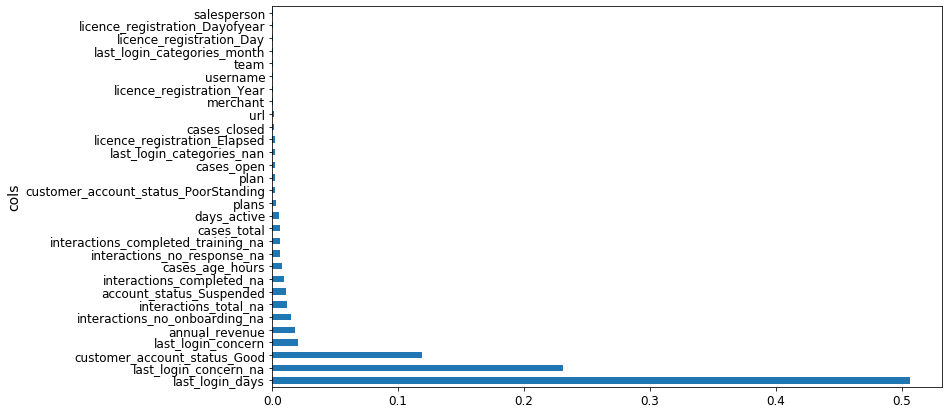

In [268]:
plot_fi(fi[:30]);

In [269]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

14

In [270]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [271]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
m.oob_score_

0.9712377064390425

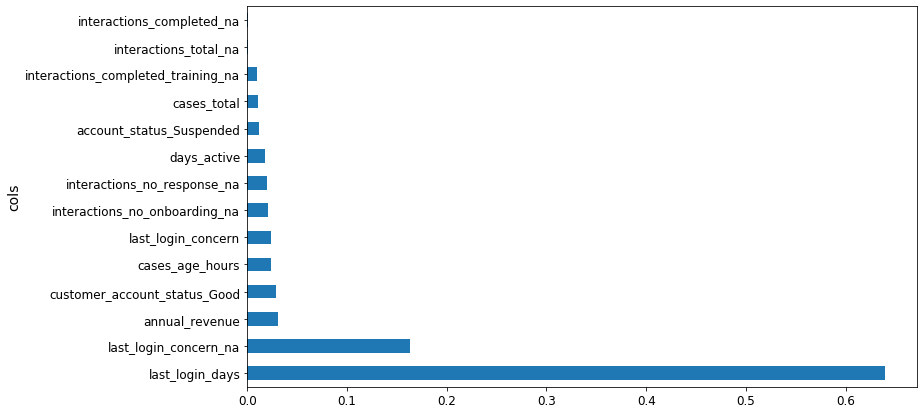

In [272]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [273]:
from scipy.cluster import hierarchy as hc

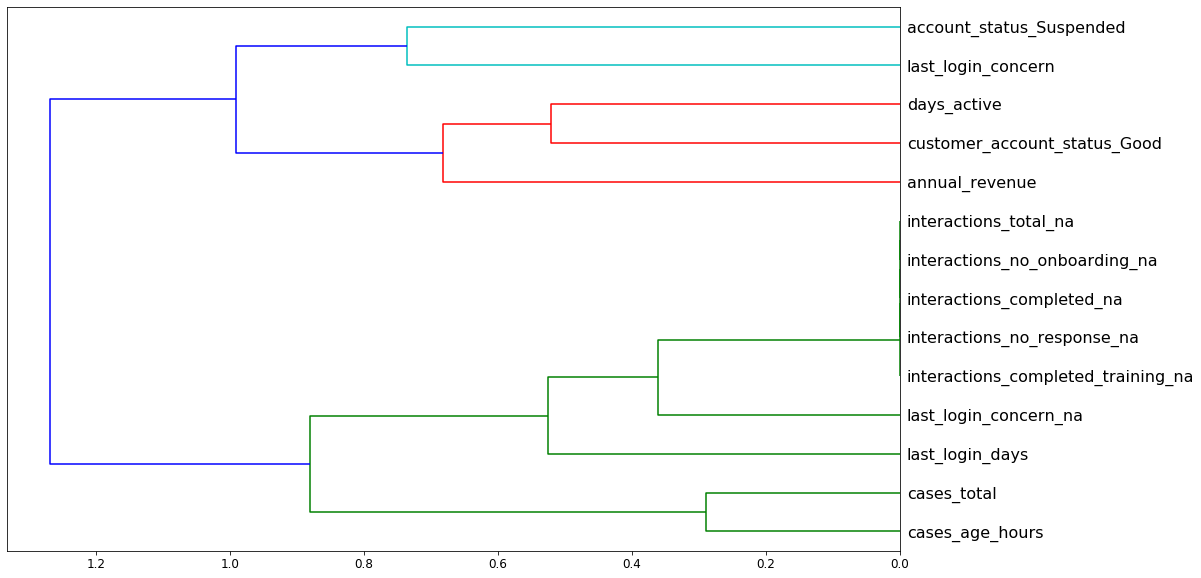

In [274]:

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [223]:
df_keep.columns

Index(['account_status_Active', 'last_login_days', 'account_status_nan',
       'last_login_concern_na', 'account_status_Cancelled',
       'customer_account_status_nan', 'account_status_Suspended',
       'account_status_Suspended', 'account_status_Suspended',
       'account_status_Suspended', 'customer_account_status_Good',
       'customer_account_status_Good', 'customer_account_status_Good',
       'customer_account_status_Good'],
      dtype='object')

In [303]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [304]:
get_oob(df_keep)

0.9641863054370013

In [305]:
correlated_fields = ['annual_revenue_na', 'interactions_no_response_na', 'interactions_no_onboarding_na', 'interactions_total_na', 'interactions_completed_training_na', 'account_status_Suspended', 'is_suspended']
for c in (correlated_fields):
    print(c, get_oob(df_keep.drop(c, axis=1)), get_oob(df_keep.drop(c, axis=1))-0.9660419372796437)

annual_revenue_na 0.9643718686212656 -0.002597884579699339
interactions_no_response_na 0.9638151790684728 -0.0027834477639636646
interactions_no_onboarding_na 0.9638151790684728 -0.002412321395435124
interactions_total_na 0.96325848951568 -0.002412321395435124
interactions_completed_training_na 0.964742994989794 -0.002597884579699339
account_status_Suspended 0.9634440526999444 -0.0022267582111709094
is_suspended 0.9627017999628874 -0.002597884579699339


In [306]:
get_oob(df_keep.drop(correlated_fields, axis=1))

0.9582482835405456

In [307]:
to_drop = ['is_suspended', 'interactions_no_onboarding_na', 'annual_revenue_na']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [308]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

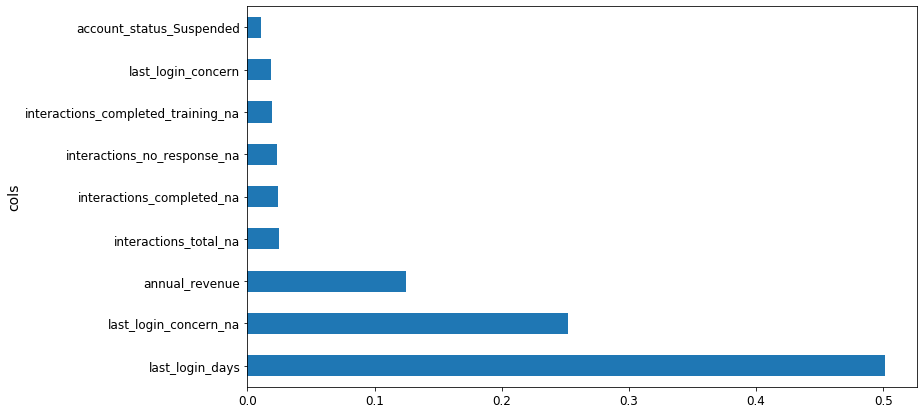

In [309]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [310]:
validate_predictions = m.predict(X_valid)
accuracy_score(y_valid, validate_predictions), f1_score(y_valid, validate_predictions)

(0.928, 0.7692307692307692)